In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt
import wandb

from spd.nathu_dev_utils import (
     
    get_experiment_df, 
    safe_first, 
    aggregate_over, 
    optimize_over, 
    get_varying_columns,
    plot_scatter_grid
)



In [3]:
from spd.registry import EXPERIMENT_REGISTRY
wandb_project = 'spd'
run_ids = ['run_20250715_003802', 'run_20250715_184638']
dfs = {}
    
for exp_name in EXPERIMENT_REGISTRY.keys():
    try:
        df = get_experiment_df(
            sweep_run_id=run_ids,
            experiment_name=exp_name,
            project=wandb_project,
        )
        if not df.empty:
            dfs[exp_name] = df
    except Exception as e:
        print(f"Error: {exp_name} - {e}")

tms_5-2 - run_20250715_003802: 0it [00:00, ?it/s]
tms_5-2 - run_20250715_184638: 0it [00:00, ?it/s]
tms_5-2-id - run_20250715_003802: 100%|██████████| 40/40 [00:00<00:00, 11201.24it/s]
tms_5-2-id - run_20250715_184638: 0it [00:00, ?it/s]
tms_40-10 - run_20250715_003802: 0it [00:00, ?it/s]
tms_40-10 - run_20250715_184638: 0it [00:00, ?it/s]
resid_mlp3 - run_20250715_184638: 100%|██████████| 20/20 [00:00<00:00, 13229.16it/s]


In [4]:
opt_dfs = {}
for experiment_name, df in dfs.items():
    if len(df) == 0:
        continue
    opt_dfs[experiment_name] = optimize_over(df, 'summary.target_solution_error/total', 
                                             params=['config.importance_minimality_coeff'], 
                                             verbose=True, aggregate_cols=['config.seed'])

Aggregating over ['config.seed'] before optimization...
When config.p_anneal_start_frac=0.25: optimal params are importance_minimality_coeff=0.003 (summary.target_solution_error/total=1.7500)
When config.p_anneal_start_frac=1.0: optimal params are importance_minimality_coeff=0.003 (summary.target_solution_error/total=11.2500)

Returning 8 unaggregated runs with optimal parameters
(from 40 total runs)
Aggregating over ['config.seed'] before optimization...
When config.p_anneal_final_p=1.0, config.p_anneal_start_frac=0.25, config.pnorm=2: optimal params are importance_minimality_coeff=0.0001 (summary.target_solution_error/total=0.0000)
When config.p_anneal_final_p=1.0, config.p_anneal_start_frac=1.0, config.pnorm=2: optimal params are importance_minimality_coeff=0.0001 (summary.target_solution_error/total=0.0000)
When config.p_anneal_final_p=nan, config.p_anneal_start_frac=1.0, config.pnorm=1: optimal params are importance_minimality_coeff=0.0001 (summary.target_solution_error/total=0.00

/mnt/polished-lake/home/nhu/spd/spd/nathu_dev_utils.py:321: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  working_df.groupby(group_cols, dropna=False).apply(get_optimal_rows, include_groups=True).reset_index(drop=True)
/mnt/polished-lake/home/nhu/spd/spd/nathu_dev_utils.py:321: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  working_df.groupby(group_cols, dropna=False).apply(get_optimal_rows, include_groups=True).reset

In [46]:
def row_to_group_name(row):
    """
    Convert a row to a group name for plotting.
    """
    if row['config.p_anneal_start_frac'] == 0.25:
        return "P-Annealing"
    else:
        return f"P-Norm = {row['config.pnorm']}"

for df in opt_dfs.values():
    if len(df) == 0:
        continue
    df['group_name'] = df.apply(row_to_group_name, axis=1)

Plotting tms_5-2-id...


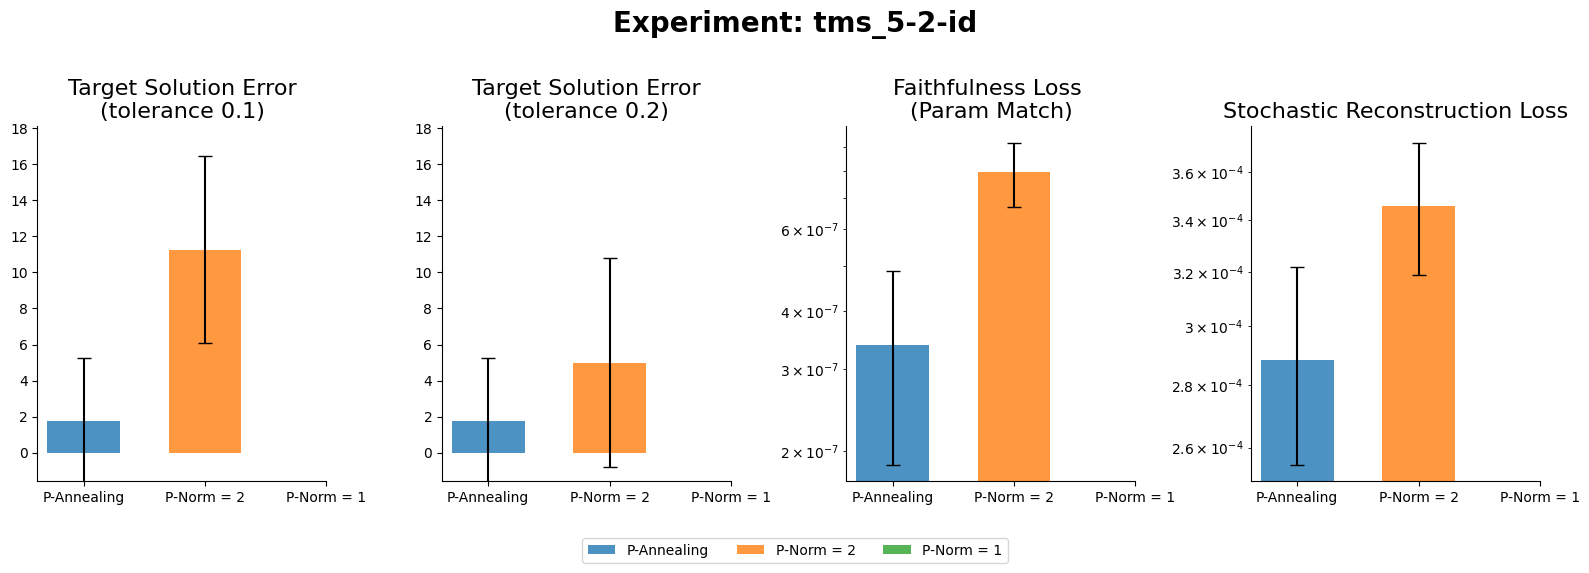

Plotting tms_40-10-id...


/tmp/ipykernel_3881721/1875500524.py:71: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(target_solution_ylims[0] * 0.9, target_solution_ylims[1] * 1.1)
/tmp/ipykernel_3881721/1875500524.py:71: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(target_solution_ylims[0] * 0.9, target_solution_ylims[1] * 1.1)


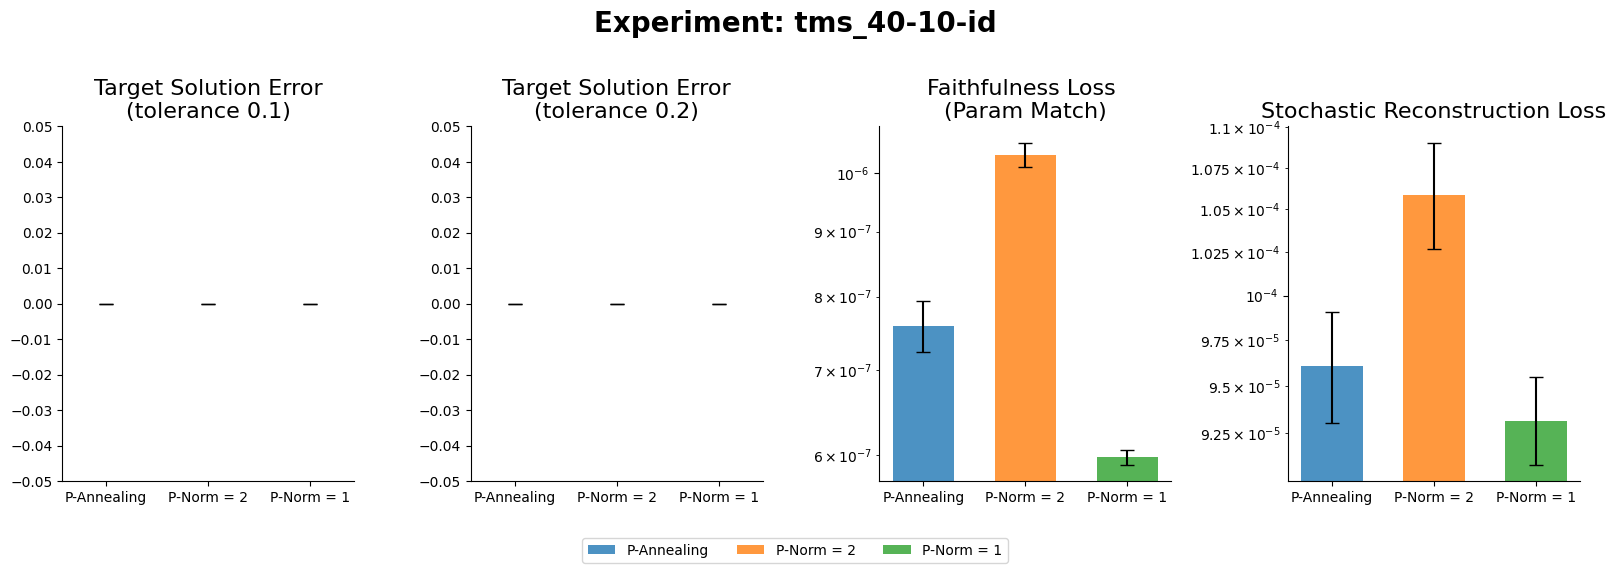

Plotting resid_mlp1...


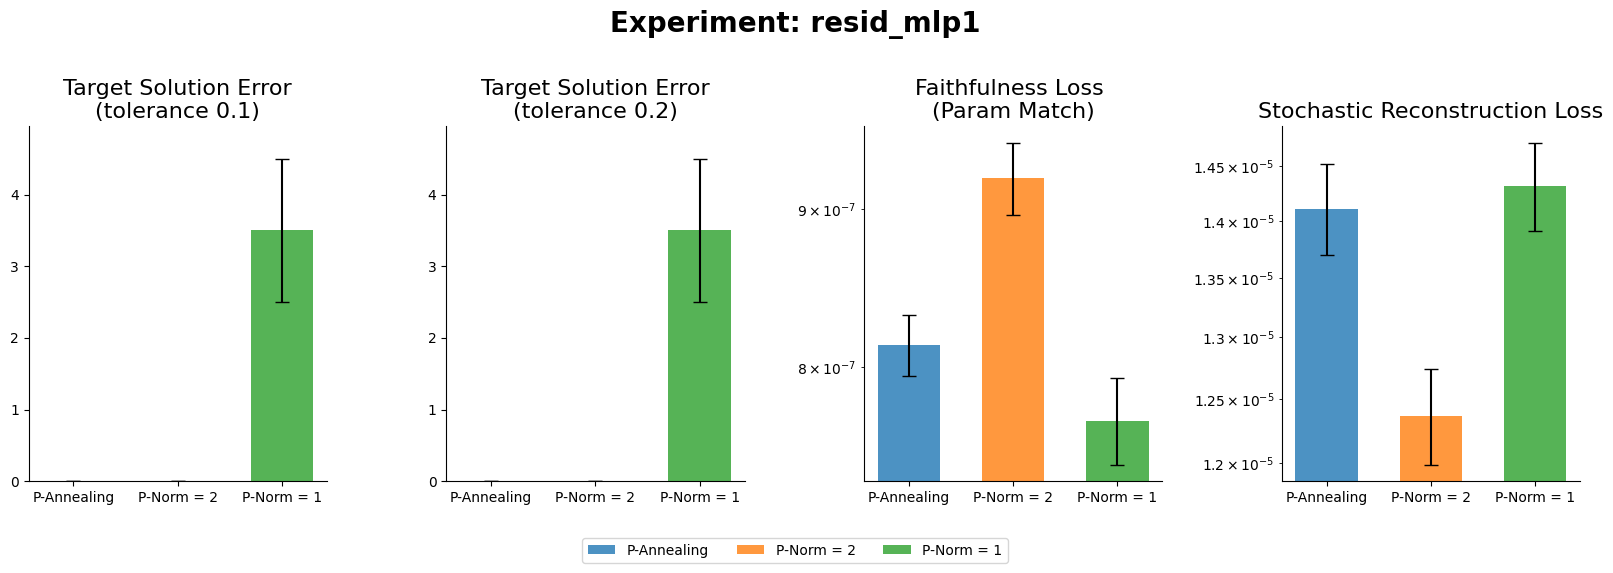

Plotting resid_mlp2...


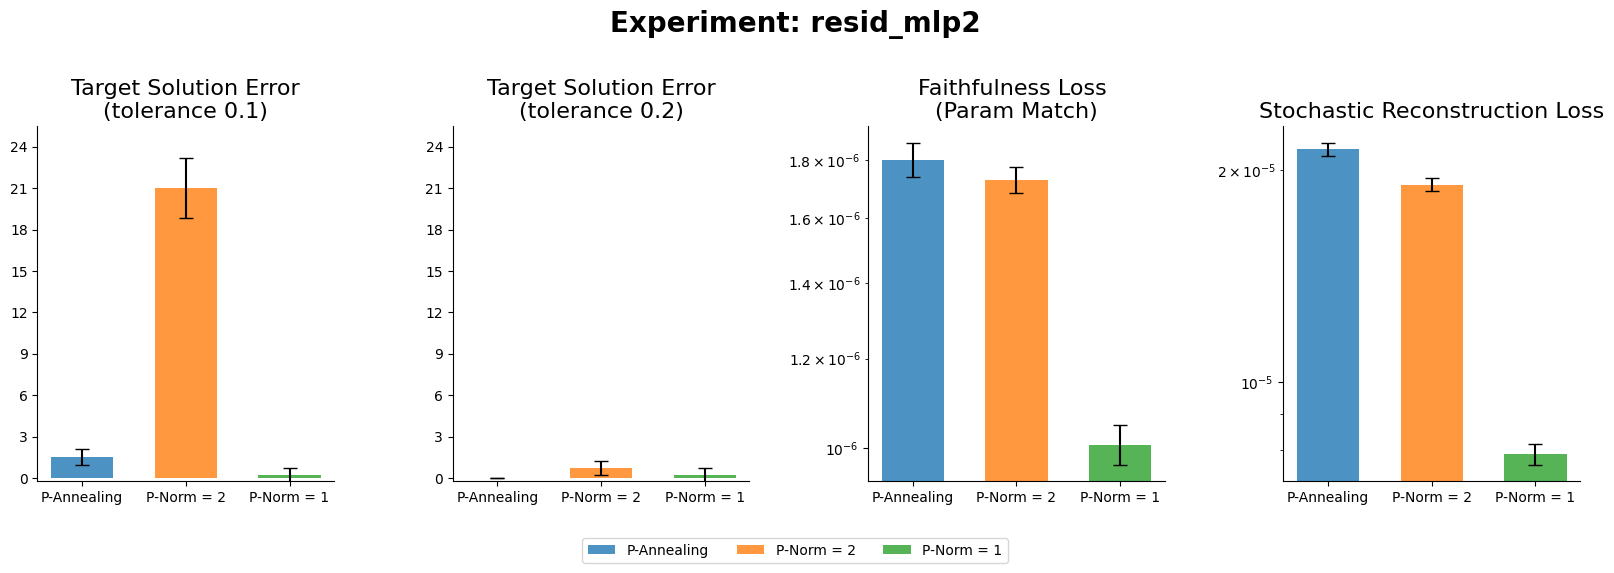

Plotting resid_mlp3...


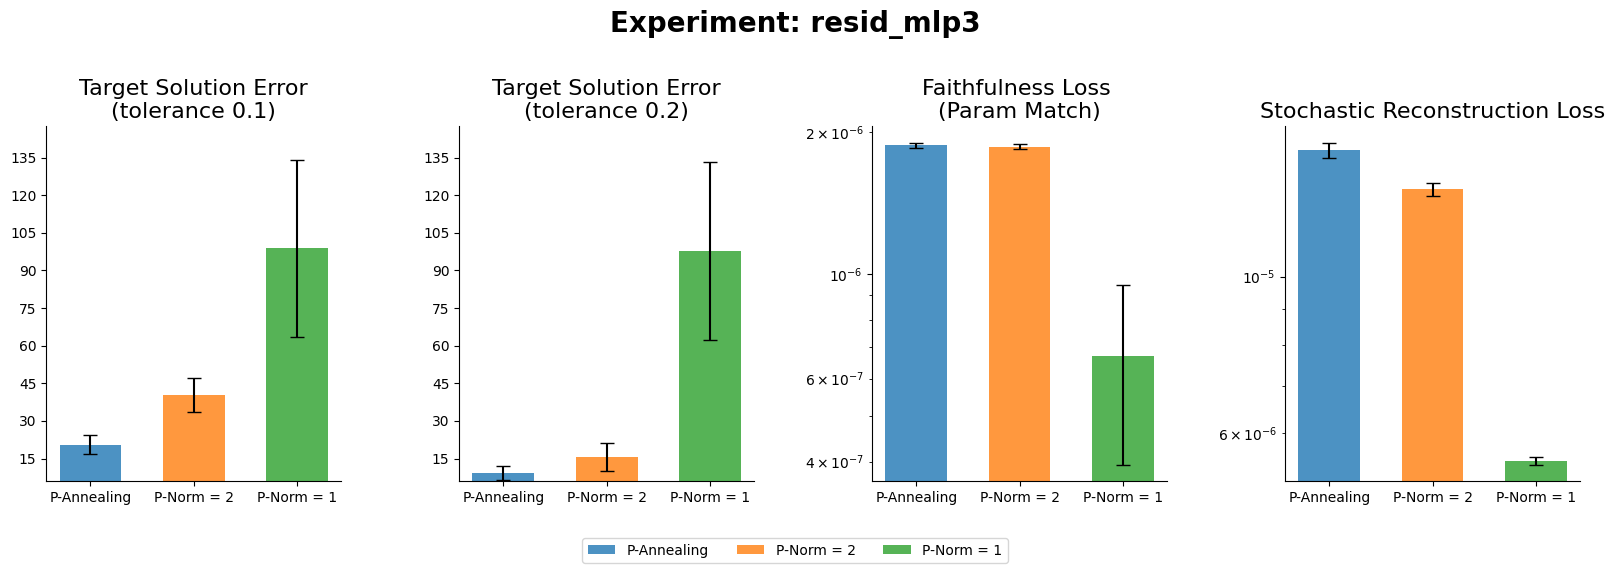

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics_by_group(df, y_cols, group_col='group_name', suptitle=None, group_order=None):
    """Create bar plots for each metric grouped by group_name."""
    
    fig, axs = plt.subplots(
        nrows=1,
        ncols=len(y_cols),
        figsize=(4 * len(y_cols), 5),
    )
    
    # Get groups in specified order or sorted
    if group_order is not None:
        groups = group_order
    else:
        groups = sorted(df[group_col].unique())
    
    colors = [f'C{i}' for i in range(len(groups))]
    
    # First pass: collect data and find y-limits for target solution error plots
    target_solution_ylims = [float('inf'), float('-inf')]
    all_plot_data = []
    
    for i, (y_col, y_label) in enumerate(y_cols.items()):
        # Calculate stats for each group
        x_pos = []
        means = []
        stds = []
        
        for j, group in enumerate(groups):
            group_data = df[df[group_col] == group][y_col]
            means.append(group_data.mean())
            stds.append(group_data.std())
            x_pos.append(j)
        
        all_plot_data.append((x_pos, means, stds, y_col, y_label))
        
        # Track min/max for target solution error plots
        if 'target_solution_error' in y_col:
            # Calculate the range including error bars
            lower_bounds = [m - s for m, s in zip(means, stds)]
            upper_bounds = [m + s for m, s in zip(means, stds)]
            target_solution_ylims[0] = min(target_solution_ylims[0], min(lower_bounds))
            target_solution_ylims[1] = max(target_solution_ylims[1], max(upper_bounds))
    
    # Second pass: create the plots
    for i, (x_pos, means, stds, y_col, y_label) in enumerate(all_plot_data):
        ax = axs[i]
        
        # Create bars
        bars = ax.bar(x_pos, means, yerr=stds, capsize=5, 
                      color=colors, alpha=0.8, width=0.6)
        
        # Formatting
        ax.set_title(y_label, fontsize=16)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(groups, rotation=0, ha='center')
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Apply different scales based on column type
        if 'loss' in y_col:
            # Log scale for loss columns
            ax.set_yscale('log')
        elif 'target_solution_error' in y_col:
            # Integer scale for target solution error columns
            ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
            # Set shared y-limits for target solution error plots
            ax.set_ylim(target_solution_ylims[0] * 0.9, target_solution_ylims[1] * 1.1)
    
    # Add legend below the plots
    fig.legend(bars, groups, loc='lower center', bbox_to_anchor=(0.5, -0.1), 
               ncol=len(groups))
    
    # Add suptitle if provided
    if suptitle:
        fig.suptitle(suptitle, y=1.02, fontsize=20, fontweight='bold')
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.4)  # Increase horizontal spacing
    return fig, axs

y_cols = {
    'summary.target_solution_error/total': "Target Solution Error\n(tolerance 0.1)",
    'summary.target_solution_error/total_0p2': "Target Solution Error\n(tolerance 0.2)",  
    'summary.loss/faithfulness': 'Faithfulness Loss \n(Param Match)',
    'summary.loss/stochastic_recon': "Stochastic Reconstruction Loss",
}

group_order = [ "P-Annealing", "P-Norm = 2", "P-Norm = 1",]

for experiment_name, df in opt_dfs.items():
    if len(df) == 0:
        continue
    print(f"Plotting {experiment_name}...")
    fig, axs = plot_metrics_by_group(df, y_cols, group_order=group_order,
                                     suptitle=f"Experiment: {experiment_name}")
    plt.show()


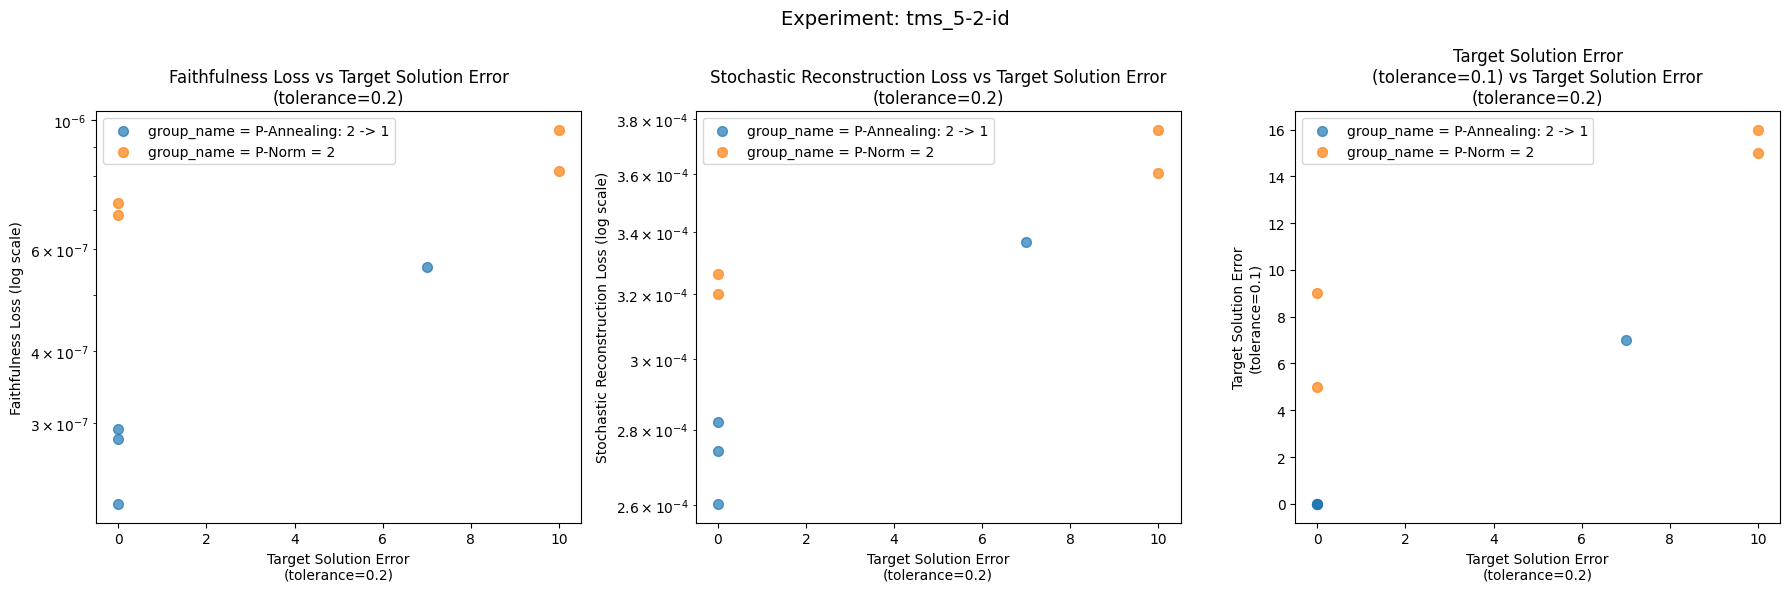

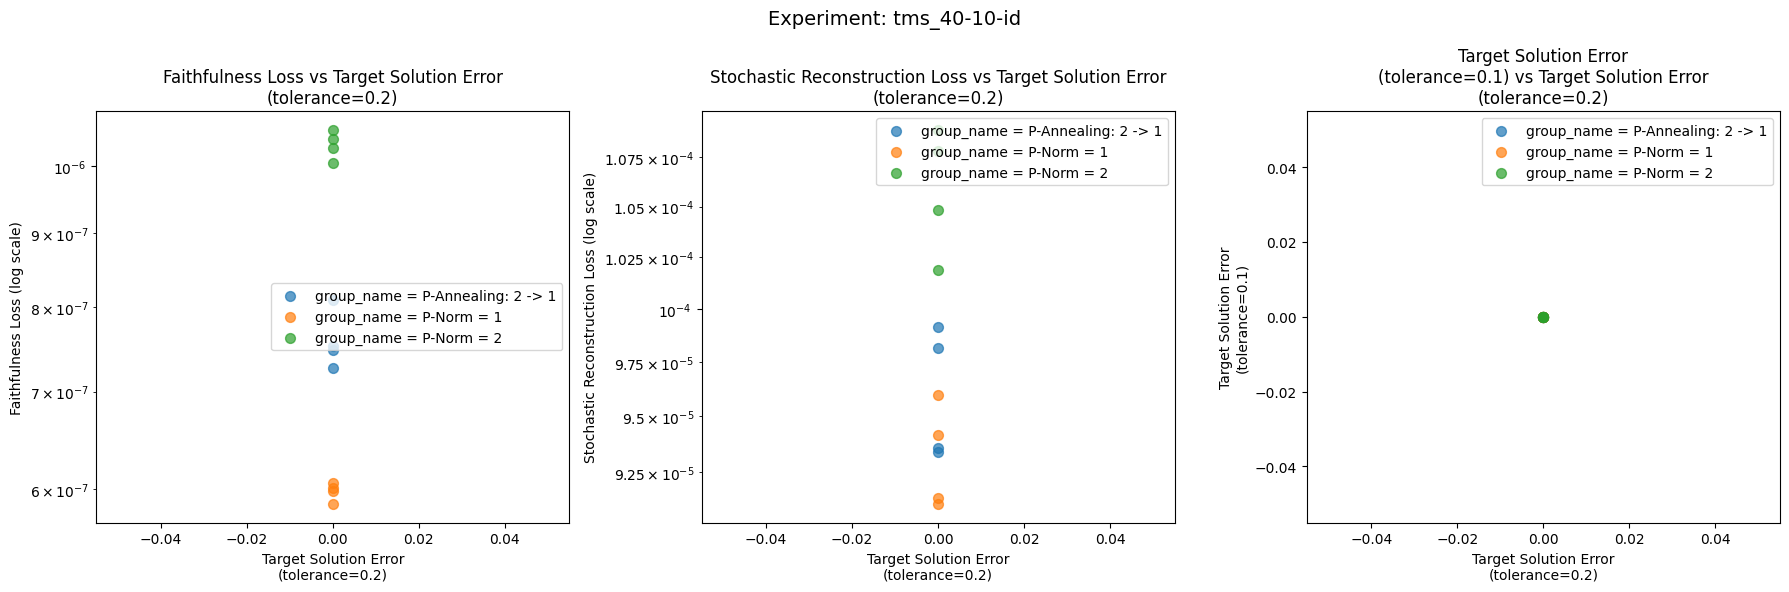

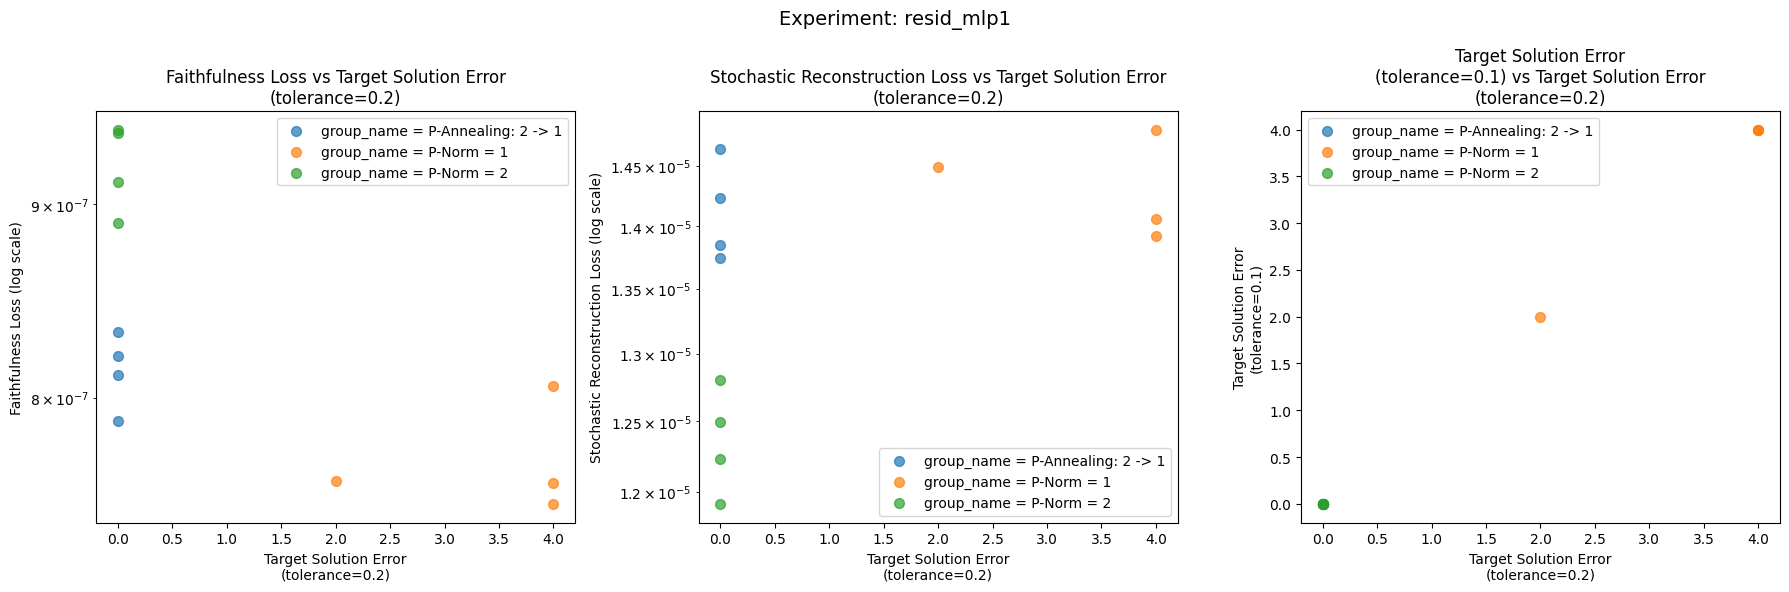

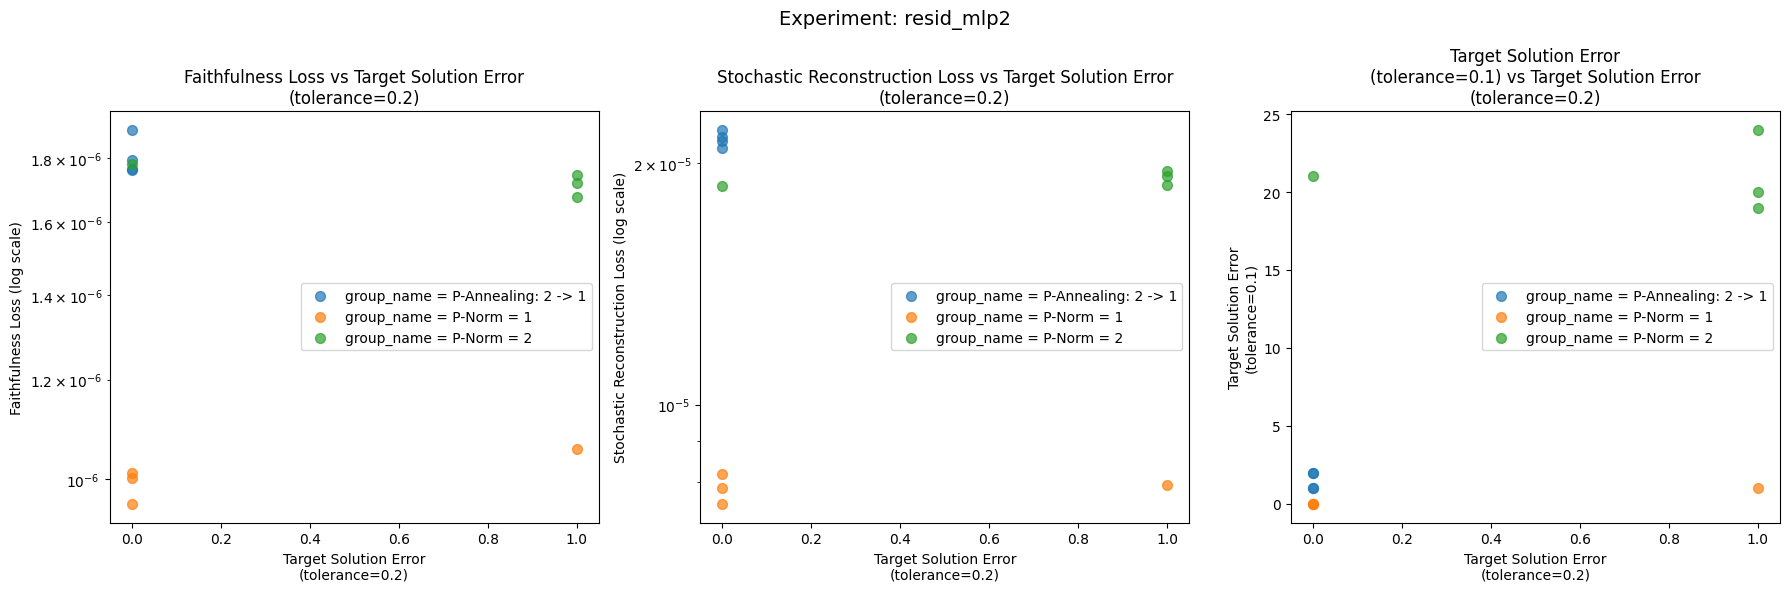

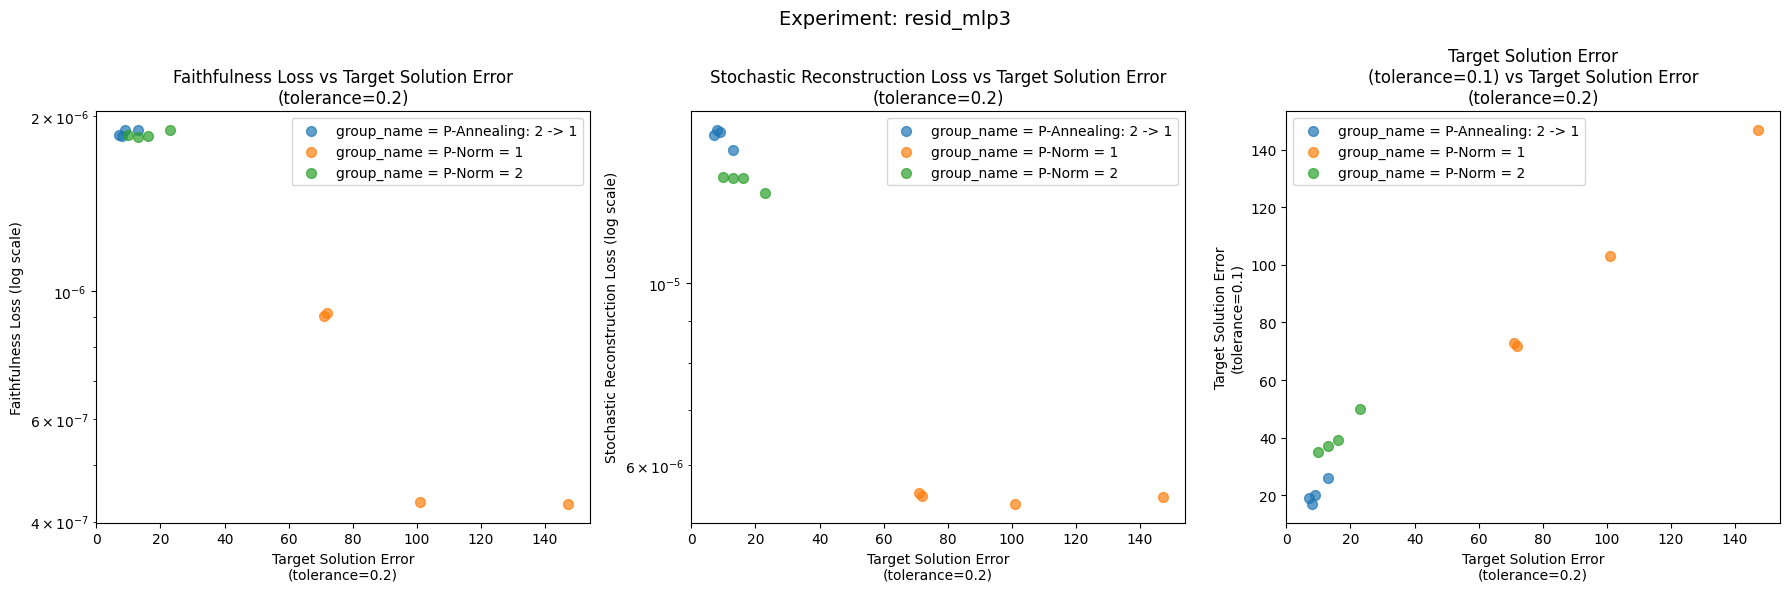

In [11]:
for experiment_name, opt_df in opt_dfs.items():
    # Usage - much simpler!
    plot_scatter_grid(
        opt_df,
        x_col='summary.target_solution_error/total_0p2',
        y_cols=[
            'summary.loss/faithfulness',
            'summary.loss/stochastic_recon',
            'summary.target_solution_error/total'
        ], 
        title=f'Experiment: {experiment_name}',
        group_col='group_name'
    )